In [1]:
# import rasterio
# from rasterio import plot
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import asf_search as asf
from datetime import datetime, date, timedelta
from typing import List
from pystac_client import Client, ItemSearch
import geopandas as gpd
from rasterio.crs import CRS
import contextily as cx

In [2]:
# for formatting the datetime object to asfsearch syntax
def datetime2asfsearch(entered_date: datetime) -> str:
    return datetime.strftime(entered_date,'%Y') + '-' + datetime.strftime(entered_date,'%m') + '-' + datetime.strftime(entered_date,'%d') + 'T' + datetime.strftime(entered_date,'%H') + ':' + datetime.strftime(entered_date,'%M') + ':' + datetime.strftime(entered_date,'%S') + 'Z'

In [92]:
# for formatting the asfsearch syntax to datetime object
def asfsearch2datetime(entered_date: str) -> datetime:
    try:
        dtime = datetime.strptime(entered_date, '%Y-%m-%dT%H:%M:%S.%f')
    except:
        dtime = datetime.strptime(entered_date, '%Y-%m-%dT%H:%M:%S.%fZ')
    return dtime

In [87]:
# for searching for sentinel2 and landsat8 data
def hls_search(sensor: str, aoi: Polygon, date: List[datetime] = None):
    STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
    api = Client.open(f'{STAC_URL}/LPCLOUD/')
    
    if 'sentinel2' in sensor.lower():
        hls_collections = ['HLSS30.v2.0']
    elif 'landsat8' in sensor.lower():
        hls_collections = ['HLSL30.v2.0']
    
    if date == None:
        search_datetime = [datetime.combine(date.today(), datetime.min.time()), datetime.now()]
    else:
        search_datetime = date
    
    x, y = aoi.exterior.coords.xy
    
    search_params = {
        "collections": hls_collections,
        "bbox": [x[0],y[0],x[1],y[1]], # list of xmin, ymin, xmax, ymax
        "datetime": search_datetime,
    }
    search_hls = api.search(**search_params)
    hls_collection = search_hls.get_all_items()
    d = list(hls_collection)
    
    return d

In [59]:
# for searching sentinel1 data
def asf_search(aoi: Polygon, date: datetime = None):
    if date == None:
        today = date.today()
        start = str(today) + 'T00:00:00Z'
        end = str(today) + 'T23:59:59Z'
    else:
        start = datetime2asfsearch(date[0])
        end = datetime2asfsearch(date[1])

    wkt = aoi.wkt
    opts = {
        'platform': asf.PLATFORM.SENTINEL1,
        'processingLevel': 'RAW',
        'start': start,
        'end': end
    }
    results = asf.geo_search(intersectsWith=wkt,**opts)
    
    return results

In [65]:
# find next acquisition date
def acq_search(sensor_name: str, aoi: Polygon, date):
    rep = 0
    acq = False
    
    # put arbitrary hard stop at 3 searches (300 days)
    while acq == False and rep < 3:

        if 'landsat8' in sensor_name.lower():
            results = hls_search('landsat8', aoi, [date + timedelta(days = 100 * rep), date + timedelta(days = 100 * (rep + 1))])
        elif 'sentinel1' in sensor_name.lower():
            results = asf_search(aoi, [date + timedelta(days = 100 * rep), date + timedelta(days = 100 * (rep + 1))])
        elif 'sentinel2' in sensor_name.lower():
            results = hls_search('sentinel2', aoi, [date + timedelta(days = 100 * rep), date + timedelta(days = 100 * (rep + 1))])
        
        coords = []
        for i in range(len(results)):
            coords.append(results[i].geometry['coordinates'][0])

        for i in range(len(results)):
            poly = Polygon(coords[i])
            if aoi.within(poly):
                acq = True
                break
            
        if acq:
            
            try:
                next_acq = results[i].properties['start_datetime']
            except:
                next_acq = results[i].properties['startTime']
        
        else:
            next_acq = 'Search yielded no results'
        rep += 1
    return next_acq

In [115]:
def get_coverage(sensor: List[str], aoi: Point, date: List[datetime] = None) -> List[dict]:
    """
    Sensor: choose sentinel1, sentinel2, landsat8
    AOI: enter coordinates as Polygon object
    date: leave as none if searching today, else enter time range as datetime tuple: datetime(YYYY,MM,DD)
    """
    freq = {}
    next_acq = {}
    area = {}
    coord = {}
    
    for sensor_name in sensor:
        freq[sensor_name] = ''
        next_acq[sensor_name] = ''
        area[sensor_name] = ''
        coord[sensor_name] = ''
        
        if 'landsat8' in sensor_name.lower():
            results = hls_search('landsat8', aoi, date)
        elif 'sentinel1' in sensor_name.lower():
            results = asf_search(aoi, date)
        elif 'sentinel2' in sensor_name.lower():
            results = hls_search('sentinel2', aoi, date)
        
        coords = []
        for i in range(len(results)):
            coords.append(results[i].geometry['coordinates'][0])
        coord[sensor_name] = coords
        
        # calculate frequency
        if len(results) == 0:
            freq[sensor_name] = 'There is no coverage during this time'
            area[sensor_name] = 0
            
        else:
            if len(results) == 1:
                try:
                    freq[sensor_name] = 'Only one acquisition on ' + results[i].properties['startTime']
                except:
                    freq[sensor_name] = 'Only one acquisition on ' + results[i].properties['start_datetime']
                    
            else:
                cadence = []
                for i in range(len(results) - 1):
                    try:
                        cadence.append(str(asfsearch2datetime(results[i].properties['startTime']) - asfsearch2datetime(results[i + 1].properties['startTime'])))
                    except:
                        cadence.append(str(asfsearch2datetime(results[i].properties['start_datetime']) - asfsearch2datetime(results[i + 1].properties['start_datetime'])))
                
                freq[sensor_name] = cadence
        
        # find next acquisition time, if search time is today then returns 'N/A'
        if date == None:
            next_acq[sensor_name] = 'N/A'
            
        else:
            next_acq[sensor_name] = acq_search(sensor_name.lower(), aoi, date[1])
                
        if len(results) != 0:
            area[sensor_name] = Polygon(coords[0])
            
            if len(results) > 1:
                
                for i in range(len(coords) - 1):
                    area[sensor_name] = area[sensor_name].intersection(Polygon(coords[i + 1]))
         
    return freq, next_acq, area, coords

Ridgecrest coordinates: Polygon([[-117.7167, 35.5909],[-117.6322, 35.5909],[-117.6322, 35.6452],[-117.7167, 35.6452],[-117.7167, 35.5909]])

Wax lake delta: Polygon((-91.4964 29.4641,-91.3849 29.4641,-91.3849 29.5627,-91.4964 29.5627,-91.4964 29.4641))

Laurentides forest in Canada: POLYGON((-75.0327 46.0832,-74.8823 46.0832,-74.8823 46.1914,-75.0327 46.1914,-75.0327 46.0832))

In [116]:
%%time
freq, next_acq, area, coord = get_coverage(['sentinel1','sentinel2','landsat8'],Polygon([[-117.7167, 35.5909],[-117.6322, 35.5909],[-117.6322, 35.6452],[-117.7167, 35.6452],[-117.7167, 35.5909]]),[datetime(2022,1,1), datetime(2022,2,1)])


CPU times: user 179 ms, sys: 28.3 ms, total: 208 ms
Wall time: 11.1 s


In [117]:
print(freq['landsat8'])
print(next_acq['landsat8'])
print(freq['sentinel1'])
print(next_acq['sentinel1'])
print(freq['sentinel2'])
print(next_acq['sentinel2'])


['-16 days, 0:00:05.079000']
2022-02-15T18:28:00.390Z
['0:00:25', '12:00:54', '11 days, 11:58:41', '0:00:25', '12:00:53', '11 days, 11:58:41', '0:00:25', '12:00:54']
2022-05-01T13:52:15.000000
['-6 days, 23:59:54.617000', '-10 days, 0:00:01.165000', '-5 days, 0:00:05.672000', '-6 days, 23:59:54.446000']
2022-02-02T18:44:24.938Z


In [50]:
# print(area['landsat8'])
print(area['sentinel1'])


POLYGON ((-118.60452208667414 35.75926029809414, -118.55879297228815 35.98693959800427, -116.63559121884143 35.79557234765206, -116.5422610839788 35.32968394090287, -118.6481048625543 35.54026048772484, -118.60452208667414 35.75926029809414))


In [122]:
type(coord)

list

In [109]:
wkt = 'POLYGON((-91.4964 29.4641,-91.3849 29.4641,-91.3849 29.5627,-91.4964 29.5627,-91.4964 29.4641))'
opts = {
    'platform': asf.PLATFORM.SENTINEL1,
    'processingLevel': 'RAW',
    'start': '2022-01-01T00:00:00Z',
    'end': '2022-01-14T23:59:59Z'
}
results = asf.search(**opts)
print(len(results))

8654


In [111]:
results[0].geometry['coordinates'][0]

[[-89.0403, 41.7012],
 [-91.9746, 41.4272],
 [-92.4497, 43.2535],
 [-89.4273, 43.5301],
 [-89.0403, 41.7012]]

In [ ]:
d[0].geometry

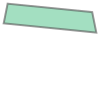

In [51]:
from shapely.geometry import shape
shape(area['sentinel1'])


# Visualization

<AxesSubplot:>

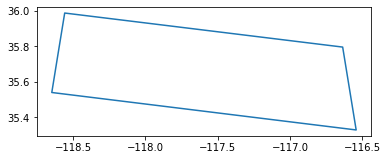

In [52]:
area = area['sentinel1']
test = gpd.GeoDataFrame(geometry = [area], 
                     crs = CRS.from_epsg(4326))
test.boundary.plot()

In [129]:
df_s1 = gpd.GeoDataFrame(geometry = [area['sentinel1']], 
                     crs = CRS.from_epsg(4326))
df_wms1 = df_s1.to_crs(epsg=3857)


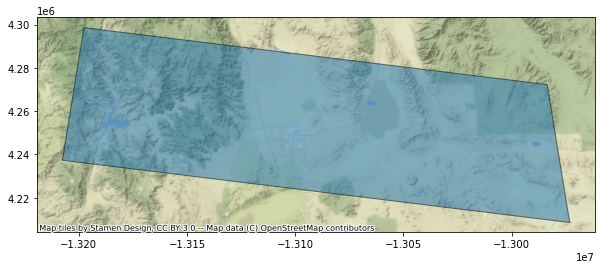

In [130]:
ax = df_wms1.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, zoom = 10)

In [125]:
df_l8 = gpd.GeoDataFrame(geometry = [area['landsat8']], 
                     crs = CRS.from_epsg(4326))
df_wml8 = df_l8.to_crs(epsg=3857)

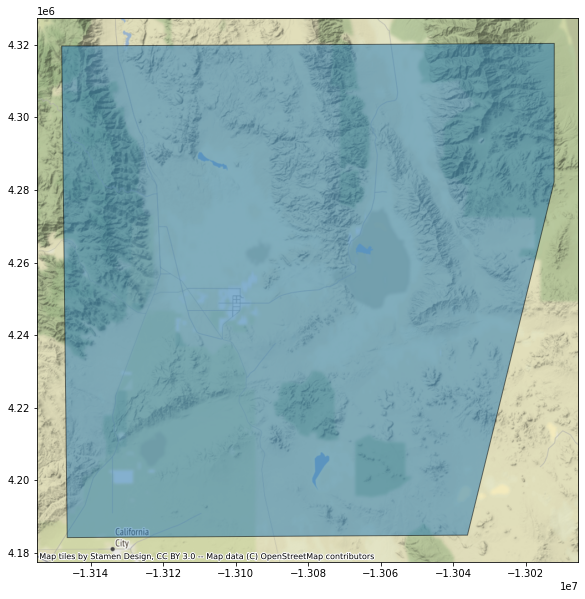

In [126]:
ax = df_wml8.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, zoom = 10)

In [127]:
df_s2 = gpd.GeoDataFrame(geometry = [area['sentinel2']], 
                     crs = CRS.from_epsg(4326))
df_wms2 = df_s2.to_crs(epsg=3857)

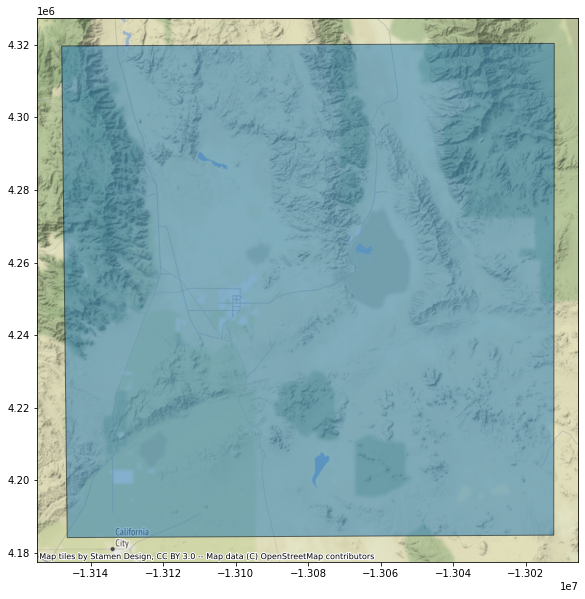

In [128]:
ax = df_wms2.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, zoom = 10)

In [ ]:
fig, ax = plt.subplots()

df_wml8.plot(ax =ax, alpha=.5)
df_wms1.plot(ax = ax, alpha=.5)

cx.add_basemap(ax, zoom = 10)

In [ ]:
results[0].properties